In [ ]:
import os
import tensorflow as tf

# Dataset by Chenghan Lu and Haolun Huang

In [ ]:
#import google drive into the colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#All the file location in the share google drive

filepath = '/content/drive/MyDrive/CSCI3397_Project/TBX11K' #gernal file pass
filepath_anno = filepath + '/annotations/json/all_trainval.json' #all the annotation in Jason file, include all the image in the TBX11K
filepath_img_train = filepath + '/imgs/train' #all the training Image (inlcude three category: health, sick, TB)
filepath_img_test = filepath + '/imgs/test' #all the test images (all display unknown and jason file have the correct label)

In [ ]:
#Exame all the annotations
import json
with open(filepath_anno, 'r') as f:
  annotations = json.load(f)
print(annotations['images'][0])

{'id': 1, 'file_name': 'tb/tb0003.png', 'width': 512, 'height': 512, 'date_captured': '2020-06-24 12:42:50.361310', 'license': 1, 'coco_url': '', 'flickr_url': ''}


In [ ]:
print(annotations['images'][0])

{'id': 1, 'file_name': 'tb/tb0003.png', 'width': 512, 'height': 512, 'date_captured': '2020-06-24 12:42:50.361310', 'license': 1, 'coco_url': '', 'flickr_url': ''}


In [ ]:
#TF split the train and validation data set from the all train 


train = tf.keras.utils.image_dataset_from_directory(
   filepath_img_train,
   validation_split=0.2,
   subset = 'training',
   seed=42, 
   image_size=(224, 224), #transfer the imgae size to the model required 224x224, instead of orginal 512x512
   batch_size=64)
val = tf.keras.utils.image_dataset_from_directory(
   filepath_img_train,
   validation_split=0.2,
   subset = 'validation',
   seed=42, 
   image_size=(224, 224),
   batch_size=64)

Found 8400 files belonging to 3 classes.
Using 6720 files for training.
Found 8400 files belonging to 3 classes.
Using 1680 files for validation.


In [ ]:
train #train had been change 

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Code from the paper

## Pre-load the function by Haolun Huang 

In [ ]:
#HAOLUN HUANG
import os
import re
import datetime
import numpy as np
from itertools import groupby
from skimage import measure
from PIL import Image
from pycocotools import mask
from math import sqrt

convert = lambda text: int(text) if text.isdigit() else text.lower()
natrual_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]

In [ ]:
#HAOLUN HUANG

convert = lambda text: int(text) if text.isdigit() else text.lower()
natrual_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]

def resize_binary_mask(array, new_size):
    image = Image.fromarray(array.astype(np.uint8)*255)
    image = image.resize(new_size)
    return np.asarray(image).astype(np.bool_)

def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
                counts.append(0)
        counts.append(len(list(elements)))

    return rle

def binary_mask_to_polygon(binary_mask, tolerance=0):
    """Converts a binary mask to COCO polygon representation

    Args:
        binary_mask: a 2D binary numpy array where '1's represent the object
        tolerance: Maximum distance from original points of polygon to approximated
            polygonal chain. If tolerance is 0, the original coordinate array is returned.

    """
    polygons = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance)
        if len(contour) < 3:
            continue
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        # after padding and subtracting 1 we may get -0.5 points in our segmentation
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)

    return polygons

def create_image_info(image_id, file_name, image_size,
                      date_captured=datetime.datetime.utcnow().isoformat(' '),
                      license_id=1, coco_url="", flickr_url=""):

    image_info = {
            "id": image_id,
            "file_name": file_name,
            "width": image_size[0],
            "height": image_size[1],
            "date_captured": date_captured,
            "license": license_id,
            "coco_url": coco_url,
            "flickr_url": flickr_url
    }

    return image_info

def create_annotation_info(annotation_id, image_id, category_info, binary_mask=None,
                           image_size=None, tolerance=2, bounding_box=None):
    assert(binary_mask is not None or image_size is not None)

    if binary_mask is not None:
        if image_size is not None:
            binary_mask = resize_binary_mask(binary_mask, image_size)
        binary_mask_encoded = mask.encode(np.asfortranarray(binary_mask.astype(np.uint8)))
        area = mask.area(binary_mask_encoded)
        bounding_box = mask.toBbox(binary_mask_encoded)
    else:
        area = np.array(bounding_box[2] * bounding_box[3], dtype=int)
    if area < 20:
        print("Area of this annotation is less than 20, Skip it! image_id:", image_id, "area:", area, "bbox:", bounding_box)
        return None
    if category_info["is_crowd"]:
        is_crowd = 1
        segmentation = binary_mask_to_rle(binary_mask)
    else :
        is_crowd = 0
        if binary_mask is not None:
            binary_mask_encoded = mask.encode
            segmentation = binary_mask_to_polygon(binary_mask, tolerance)
            if not segmentation:
                return None
    if binary_mask is not None:
        annotation_info = {
            "id": annotation_id,
            "image_id": image_id,
            "category_id": category_info["id"],
            "iscrowd": is_crowd,
            "area": area.tolist(),
            "bbox": bounding_box.tolist(),
            "segmentation": segmentation,
            "width": binary_mask.shape[1],
            "height": binary_mask.shape[0],
        }
    else:
        annotation_info = {
            "id": annotation_id,
            "image_id": image_id,
            "category_id": category_info["id"],
            "iscrowd": is_crowd,
            "area": area.tolist(),
            "bbox": bounding_box.tolist(),
            "width": image_size[0],
            "height": image_size[1],
        }

    return annotation_info


In [ ]:
##

# EfficientNetV2 Model by Chenghan Lu 

In [ ]:
#load the env and Install the model 

!pip install tensorflow



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%capture
#Load all the files
!pip install tensorflow_addons

import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientnetv2" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientnetv2')
  sys.path.append('.')
else:
  !git pull

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{m}.tgz
    !tar zxf {m}.tgz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

In [ ]:
import effnetv2_model

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnetv2_model.get_model('efficientnetv2-b0', include_top=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(3, activation='softmax'),
])

105641132/105641132 [==============================] - 6s 0us/step


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (EffNetV2  (None, 1280)             5919312   
 Model)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5,923,155
Trainable params: 5,862,547
Non-trainable params: 60,608
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.SGD()+

loss=tf.keras.losses.SparseCategoricalCrossentropy()

metrics = tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy')

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
history = model.fit(train,
                    epochs = 100, 
                    batch_size = 64, 
                    validation_data = val)

Epoch 1/100
105/105 [==============================] - 2343s 21s/step - loss: 0.5652 - sparse_categorical_accuracy: 0.8088 - val_loss: 0.5111 - val_sparse_categorical_accuracy: 0.9042
Epoch 2/100
105/105 [==============================] - 1959s 19s/step - loss: 0.2479 - sparse_categorical_accuracy: 0.9241 - val_loss: 0.2507 - val_sparse_categorical_accuracy: 0.9417
Epoch 3/100
105/105 [==============================] - 1848s 18s/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.2114 - val_sparse_categorical_accuracy: 0.9548
Epoch 4/100
105/105 [==============================] - 1732s 16s/step - loss: 0.1212 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.0921 - val_sparse_categorical_accuracy: 0.9762
Epoch 5/100
105/105 [==============================] - 1697s 16s/step - loss: 0.1012 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.1125 - val_sparse_categorical_accuracy: 0.9649
Epoch 6/100
105/105 [==============================] - 1686s 16s/step - loss: 0.

KeyboardInterrupt: ignored

In [ ]:
#Apply the model to the test img set
#


# Visualization by Haolun huang 

In [ ]:
###
Epoch 1/100
105/105 [==============================] - 2343s 21s/step - loss: 0.5652 - sparse_categorical_accuracy: 0.8088 - val_loss: 0.5111 - val_sparse_categorical_accuracy: 0.9042
Epoch 2/100
105/105 [==============================] - 1959s 19s/step - loss: 0.5652 - sparse_categorical_accuracy: 0.9241 - val_loss: 0.2507 - val_sparse_categorical_accuracy: 0.9417
Epoch 3/100
105/105 [==============================] - 1848s 18s/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.2114 - val_sparse_categorical_accuracy: 0.9548
Epoch 4/100
105/105 [==============================] - 1732s 16s/step - loss: 0.1212 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.0921 - val_sparse_categorical_accuracy: 0.9762
Epoch 5/100
105/105 [==============================] - 1697s 16s/step - loss: 0.1012 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.1125 - val_sparse_categorical_accuracy: 0.9649
Epoch 6/100
105/105 [==============================] - 1686s 16s/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.0838 - val_sparse_categorical_accuracy: 0.9756
Epoch 7/100
105/105 [==============================] - 1722s 16s/step - loss: 0.0713 - sparse_categorical_accuracy: 0.9799 - val_loss: 0.0637 - val_sparse_categorical_accuracy: 0.9774
Epoch 8/100
105/105 [==============================] - 1641s 16s/step - loss: 0.0646 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.0635 - val_sparse_categorical_accuracy: 0.9792
Epoch 9/100
105/105 [==============================] - 1664s 16s/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.0654 - val_sparse_categorical_accuracy: 0.9792
Epoch 10/100
105/105 [==============================] - 1579s 15s/step - loss: 0.0507 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.0622 - val_sparse_categorical_accuracy: 0.9804
###

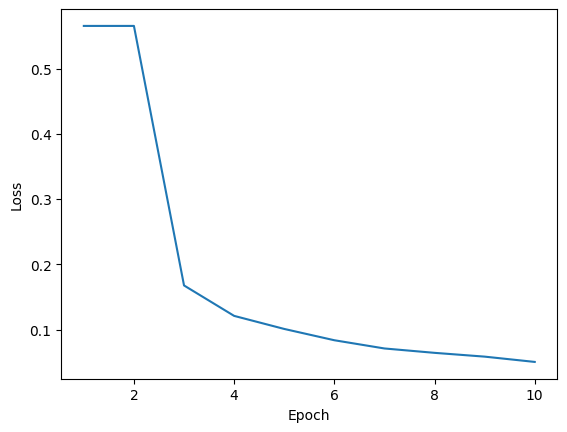

In [ ]:
#BY HAOLUN Huang

import matplotlib.pyplot as plt
import numpy as np

loss = np.array([0.5652,0.5652,0.1678,0.1212,0.1012,0.0839,0.0713,0.0646,0.0588,0.0507])
accuracy = np.array([0.9042,0.9417,0.9548,0.9762,0.9649,0.9756,0.9774,0.9792,0.9792,0.9804])
ypoints = np.array([1,2,3,4,5,6,7,8,9,10])
plt.plot(ypoints,loss,label='Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()



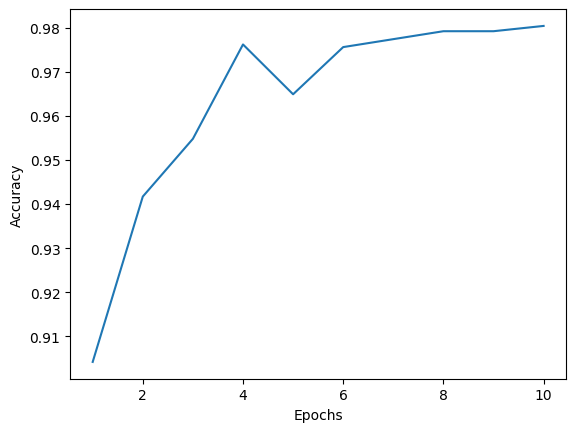

In [ ]:
plt.plot(ypoints,accuracy,label='accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()